# Getting started with real data : The concrete data set

Available at this adress : https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as met
from sklearn.base import clone
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.linear_model import RidgeCV
from hyperopt import fmin as hyperopt_fmin
from hyperopt import tpe, hp, STATUS_OK, space_eval
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from GeneralizedAdditivRegressor import GeneralizedAdditiveRegressor

def sorted_plot(X, Y, ls='-', c='blue', label=''):
    """
    sort the data according to X's axis to have nice plot
    :return 0
    """
    graphics = np.empty(shape = (X.shape[0], 2))
    graphics[:X.shape[0], 0] = X.reshape((X.shape[0],))  # sorting the data for the plot Y_pred vs X1
    graphics.sort(axis=0)
    graphics[:X.shape[0], 1] = Y.reshape((X.shape[0],))[X.reshape((X.shape[0],)).argsort(axis=0)]

    plt.plot(graphics[:, 0], graphics[:, 1], linestyle=ls, color=c, label=label)

    return 0


In [2]:
df = pd.read_excel('Concrete_Data.xls', header=0).dropna()
X = df.iloc[:, 0:8].values
Y = df.iloc[:, 8].values - df.iloc[:,8].mean() #/ df.iloc[:, 8].std()
p=8
n=1030
nugget = 1e-2
kernel = C(1.)*RBF(100)
idx_train, idx_test = train_test_split(np.arange(0, n, 1),  train_size=0.7, random_state=0)
n_train = len(idx_train)
n_test = len(idx_test)
X_train = X[idx_train]
X_test = X[idx_test]
Y_train = Y[idx_train]
Y_test = Y[idx_test]

In [3]:
df.describe()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


#  Baseline (Random Forest)

In [4]:
baseline = RandomForestRegressor()
baseline.fit(X_train, Y_train)
baseline_y_pred = baseline.predict(X_test)
rmse = np.sqrt(met.mean_squared_error(baseline_y_pred - baseline_y_pred.mean(), Y_test - Y_test.mean()))
print('RMSE = %s'%rmse)

RMSE = 5.53846808371


# No hyperopt

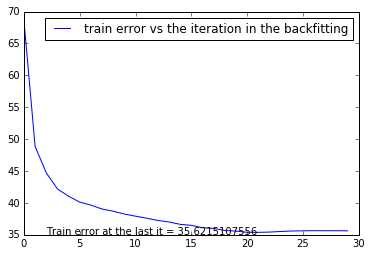

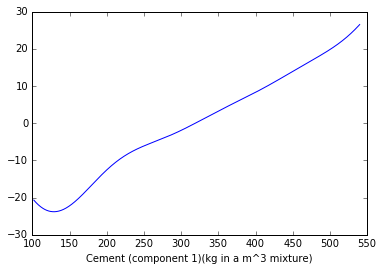

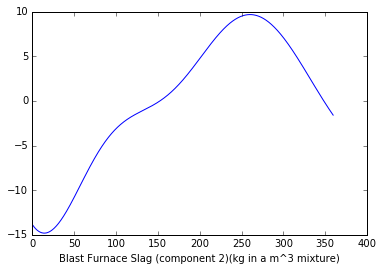

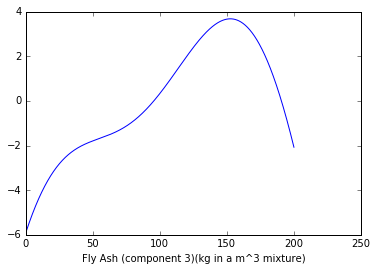

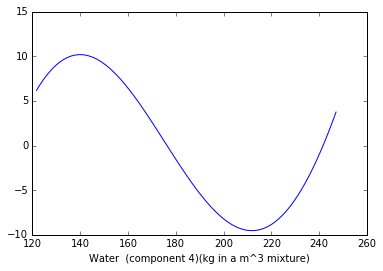

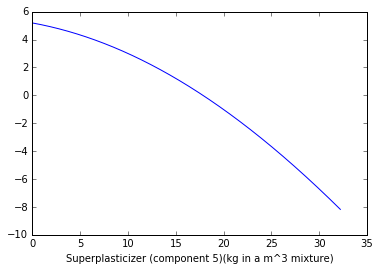

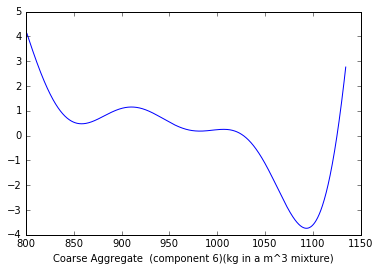

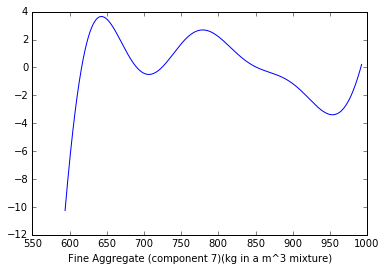

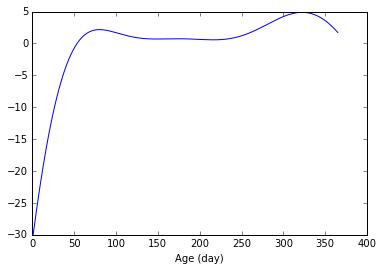

5.85883316821


In [8]:
smoothers = []
for j in np.arange(0, p, 1):
    smoothers.append(GaussianProcessRegressor(alpha=nugget, kernel=clone(kernel), optimizer=None))
    #smoothers.append(RandomForestRegressor(n_estimators=5, max_depth=10, n_jobs=-1))
    #smoothers.append(svm.SVR(C=100))

#smoothers[2].kernel.set_params(k1__constant_value = 30., k2__length_scale=30.)
    
gam = GeneralizedAdditiveRegressor(smoothers, max_iter=30)
gam.fit(X_train, Y_train)

plt.plot(range(len(gam.rmse_)), gam.rmse_, label='train error vs the iteration in the backfitting')
plt.legend(loc='best')
plt.annotate('Train error at the last it = %s'%gam.rmse_[-1], xy=(2,35))
plt.show()
for j, feature in zip(range(p), df.columns) :
    xx = np.linspace(np.amin(X[idx_train, j]), np.amax(X[idx_train, j]), 1000).reshape(1000,1)
    f_hat = gam.smoothers[j].predict(xx)
    plt.plot(xx, f_hat - f_hat.mean())
    plt.xlabel(feature)
    plt.show()

y_pred = gam.predict(X[idx_test])
rmse = np.sqrt(met.mean_squared_error(y_pred - y_pred.mean(), Y_test - Y_test.mean()))
print(rmse)

# Hyper-op with ridge regression 

In [9]:
def obj_function(param):
    """obj_func for hyperopt on a GAM with 0.18 GP as smoothers"""
    
    n_features = (len(param) - 2)//2 
    
    #print('param={0}'.format(param))
    shape_parameters = [0]*(2*n_features) #a list of dict to contain the parameters of each GP
    c=0
    i=0
    while i <= 2* n_features - 1 :
        #print('iteration nb : %s'%obj_function.nb_iter)
        shape_parameters[c] = {}
        shape_parameters[c]['constant_value'] = param[i]
        shape_parameters[c]['length_scale'] = param[i+1]
        i=i+2
        c+=1
    alpha_ = param[-2]  # all the GPs share the same nugget (noise variance estimation)
    ridge_alphas = param[-1]
    smoothers=[]
    for i in range(n_features):      
        constant_value = shape_parameters[i]['constant_value']
        length_scale = shape_parameters[i]['length_scale']
        
        smoothers.append(GaussianProcessRegressor(kernel=C(constant_value)*RBF(length_scale), alpha=alpha_, optimizer=None))
    
    gam = GeneralizedAdditiveRegressor(smoothers, max_iter=25, ridge_alphas=ridge_alphas)
    gam.fit(X_train, Y_train)
    y_pred = gam.predict(X_test)
    score =  met.mean_squared_error(Y_test - Y_test.mean(), y_pred - y_pred.mean())
    #print('score=%s \n'%score)
    return score


def create_space(n_feature):
    """ Function to create a search space for the hypers of the a sklearn 0.18 GP kernel.
    The order of the hypers is designed to work with  obj_function().
    Return a search space for hyper-opt"""
    
    n_sample = X_train.shape[0]
    size = [ X[:, i].max() - X[:, i].min() for i in range(n_feature)]
    
    constant_space = [hp.loguniform('constant_value%s'%i, np.log(10)*-2, np.log(10)*2) for i in range(n_feature)]
    l_scale_space = [hp.uniform('length_scale%s'%i, (size[i]/n_sample), size[i]) for i in range(n_feature)]
    space =[]
    #create an alternate search space for hyper-opt
    for j in range(n_feature):
        space.append(constant_space[j])
        space.append(l_scale_space[j])
    
    space.append(hp.loguniform('alpha', -11, 2))
    space.append(hp.loguniform('ridge', -2, 2))
    
    return space

In [10]:
space = create_space(p)
best = hyperopt_fmin(obj_function,
                     space = space,
                     algo=tpe.suggest,
                     max_evals=20
                    )

length=[]; constant=[];
for key in sorted(best.keys()):
    if 'alpha' in key:
        alpha_=best[key]
    if 'length' in key:
        length.append(best[key])
    if 'constant' in key:
        constant.append(best[key])
    if 'ridge' in key:
        ridge_alphas = best[key]


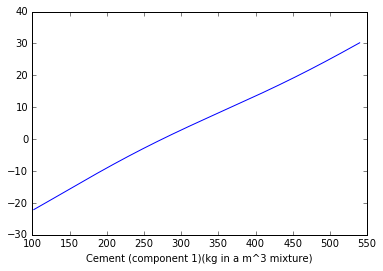

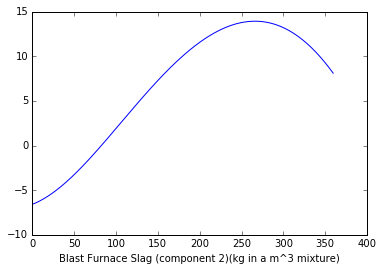

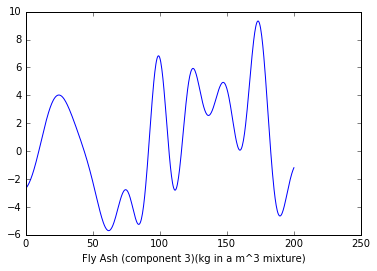

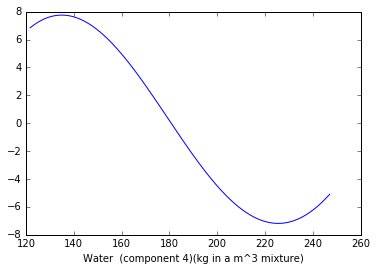

In [ ]:
smoothers=[]

for i in range(p):
    smoothers.append(GaussianProcessRegressor(kernel=C(constant[i])*RBF(length[i]), alpha=alpha_, optimizer=None))
    
gam_optimized = GeneralizedAdditiveRegressor(smoothers, max_iter=20, ridge_alphas=ridge_alphas)
gam_optimized.fit(X_train, Y_train)


for j, feature in zip(range(p), df.columns) :
    xx = np.linspace(np.amin(X[idx_train, j]), np.amax(X[idx_train, j]), 500).reshape(500,1)
    f_hat = gam_optimized.smoothers[j].predict(xx)
    plt.plot(xx, f_hat)
    plt.xlabel(feature)
    plt.show() 
    
"""

for j in range(p):
    f_hat = gam_optimized.smoothers[j].predict(X[idx_test, j].reshape(-1, 1))
    plt.scatter(X[idx_test, j], f_hat)
    plt.show()
"""

y_pred = gam_optimized.predict(X[idx_test])
rmse = np.sqrt(met.mean_squared_error(y_pred - y_pred.mean(), Y_test - Y_test.mean()))
print('test RMSE = %s'%rmse)
res = y_pred - y_pred.mean()- Y_test - y_pred.mean()
print(res.shape)
print(ridge_alphas)